In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

%matplotlib inline

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
return false; 
}

<IPython.core.display.Javascript object>

In [4]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


### Finally using all that cleaned data!

In [6]:
with open("last_4_data.pkl", 'rb') as picklefile: 
    dfl4 = pickle.load(picklefile)

In [7]:
with open("df_qr.pkl", 'rb') as picklefile: 
    df_c = pickle.load(picklefile)

* If we didnt inspect it, it's not really a valid datapoint

In [8]:
df_c = df_c[df_c.RESULTcount > 0]
del df_c['RESULTcount']

* Update the reponse to rats/no rats

In [9]:

df_c['RESULT'] = df_c.apply(lambda x: 'Passed Inspection' if x['RESULTsum'] == 0 else 'Active Rat Signs', axis=1)
del df_c['RESULTsum']

* Merge last 4 quarter data with actuals

In [10]:
df_t = df_c.merge(dfl4, on=['INSPECTION_YEAR_Q','BLOCK'])

* Importing Bronx and MN Lot Data (from PLUTO cleaning) - Inital_Cleaning.ipynb

In [19]:
with open("lot_data.pkl", 'rb') as picklefile: 
    df_lot = pickle.load(picklefile)

* Going to take percentages of certain columns (by block) because of binning (categoricals)

In [20]:
cols_to_per = ['Block','LandUse','OwnerType','SanitBoro','SanitDistrict','SanitSub','ProxCode',
               'BsmtCode','HistDist','PFIRM15_FLAG','Zoning','Commercial_Overlay','Height_Limited','IrrLotCode']
df_lot_totals = df_lot[cols_to_per]
dummies = ['LandUse','OwnerType','SanitBoro','SanitDistrict','SanitSub','ProxCode','BsmtCode','Zoning','IrrLotCode']
df_lot_totals = pd.get_dummies(df_lot_totals, columns = dummies, drop_first=False)

In [21]:
df_block_count = df_lot.reset_index().groupby('Block', as_index=False)['index'].count()

In [22]:
d = {}
for col in df_lot_totals.columns[1:]:
    d[col] = 'sum'

In [23]:
df_block_sum = df_lot_totals.groupby('Block', as_index=False).agg(d)

In [24]:
df_block_dum = df_block_sum.merge(df_block_count, on='Block')

In [25]:
for col in df_block_sum.columns[1:]:
    df_block_dum[col] = df_block_dum.apply(lambda x: x[col]/x['index'], axis=1)

* Calculate last year building was altered

In [26]:
df_lot['LastAlterYear'] = df_lot.apply(lambda x: max(x['YearBuilt'],x['YearAlter1'],x['YearAlter1']), axis=1)

* Sum & Medians of continuous columns as seems logical

In [27]:
cols_to_sum = ['Easements','LotArea','BldgArea','ComArea','ResArea','OfficeArea','RetailArea','GarageArea',
               'StrgeArea','FactryArea','OtherArea','NumBldgs']
cols_to_median = ['NumFloors','UnitsRes','UnitsTotal','LotFront','LotDepth','BldgFront','BldgDepth',
                  'AssessLand','AssessTot','ExemptLand','ExemptTot','YearBuilt','XCoord','YCoord', 
                  'LastAlterYear','BuiltFAR','ResidFAR','CommFAR','FacilFAR']

In [28]:
d = {}
for col in cols_to_sum:
    d[col] = 'sum'
for col in cols_to_median:
    d[col] = 'median'


In [29]:
df_block = df_lot.groupby('Block',as_index=False).agg(d)

In [30]:
df_block=df_block[df_block.LotArea > 0]

* Helper function to take percentage

In [31]:
def rwp(little,big):
    global df_block
    df_block[little + '_per'] = df_block.apply(lambda x: x[little]/x[big], axis=1)

In [32]:
df_block['TotArea'] = (df_block.BldgArea + df_block.ComArea + df_block.ResArea
                        + df_block.OfficeArea + df_block.RetailArea + df_block.GarageArea
                        + df_block.StrgeArea + df_block.FactryArea + df_block.OtherArea + df_block.LotArea)
cols_to_per = ['BldgArea','ComArea','ResArea','OfficeArea','RetailArea','GarageArea',
               'StrgeArea','FactryArea','OtherArea','LotArea']
for col in cols_to_per:
    rwp(col,'TotArea')

In [33]:
df_block = df_block[df_block.LotFront > 0]
df_block = df_block[df_block.LotDepth > 0]

In [34]:
df_block['build_per_lot'] = df_block.apply(lambda x:(x['BldgFront']*x['BldgDepth'])/(x['LotFront'] * x['LotDepth']),axis=1)

### Merge rat inspection data with block data!

In [35]:
df_block_t = df_block.merge(df_block_dum, on='Block')

In [36]:
df_f = df_t.merge(df_block_t, left_on='BLOCK', right_on = 'Block')

### Merge baiting and compliance data with what we've already got

In [37]:
with open("last_4_bait_data.pkl", 'rb') as picklefile: 
    df_bait = pickle.load(picklefile)

In [38]:
with open("last_4_comp_data.pkl", 'rb') as picklefile: 
    df_comp = pickle.load(picklefile)

In [39]:
df_bait = df_bait.merge(df_comp, on=['BLOCK','INSPECTION_YEAR_Q'])

In [40]:
df_f = df_f.merge(df_bait, on=['BLOCK','INSPECTION_YEAR_Q'])

* Quick Data Viz Post Binning

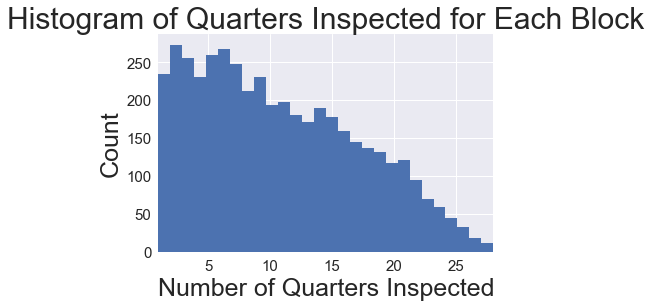

In [41]:
df_g = df_f.groupby('BLOCK', as_index=False).INSPECTION_YEAR_Q.count()
#plt.figure(figsize = (15,10))
plt.hist(df_g.INSPECTION_YEAR_Q, bins=28)
plt.xlabel('Number of Quarters Inspected', fontsize=25)
plt.ylabel('Count', fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize=15)
plt.xlim([1,28])
plt.title('Histogram of Quarters Inspected for Each Block', fontsize = 30);

* Break up by year & quarter to be used as features

In [42]:
df_f['year'] = df_f.apply(lambda x: int(x['INSPECTION_YEAR_Q'][:4]), axis=1)
df_f['quarter'] = df_f.apply(lambda x: x['INSPECTION_YEAR_Q'][-2:], axis=1)

#del df_f['INSPECTION_YEAR_Q']
del df_f['BLOCK']
del df_f['Block']


In [43]:
dummies = ['quarter']

df_f = pd.get_dummies(df_f, columns = dummies, drop_first=True)

In [44]:
#pickle it so we dont have to keep doing that!
with open('final_data.pkl', 'wb') as picklefile:
    pickle.dump(df_f, picklefile)

In [45]:
with open("final_data.pkl", 'rb') as picklefile: 
    df_f = pickle.load(picklefile)

### Train test split on last 2 years of data

In [46]:
#TTS
X_train = df_f[df_f['INSPECTION_YEAR_Q'] < '2016 Q1'].iloc[:,2:]
X_test = df_f[df_f['INSPECTION_YEAR_Q'] >= '2016 Q1'].iloc[:,2:]
y_train = df_f[df_f['INSPECTION_YEAR_Q'] < '2016 Q1'].iloc[:,1]
y_test = df_f[df_f['INSPECTION_YEAR_Q'] >= '2016 Q1'].iloc[:,1]

In [47]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

### Modeling!
* Random Forest
* Random Forest Grid Search (ehhhh)
* Logistic Regression
* Gaussian NB
* Bernoulli NB (ehhhh)

In [48]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth =32, max_features='auto', min_samples_split=32, n_estimators=50)
clf.fit(X_train, y_train)
clf.score(X_test,y_test)
#max_depth =32, max_features='auto', min_samples_split=32, n_estimators=50

print('Train Accuracy: ' + str(accuracy_score(y_train,clf.predict(X_train))))
print('Accuracy: ' + str(accuracy_score(y_test,clf.predict(X_test))))
print('Precision: ' + str(precision_score(y_test,clf.predict(X_test), pos_label = 'Active Rat Signs')))
print('Recall: ' + str(recall_score(y_test,clf.predict(X_test), pos_label = 'Active Rat Signs')))
print('F1: ' + str(f1_score(y_test,clf.predict(X_test), pos_label = 'Active Rat Signs')))

Train Accuracy: 0.858157788602
Accuracy: 0.706968158745
Precision: 0.714653271257
Recall: 0.733802994087
F1: 0.724101545528


In [49]:
from sklearn.metrics import confusion_matrix
tp, fn, fp, tn = confusion_matrix(y_test,clf.predict(X_test)).ravel()
print('True Positives: ' + str(tp))
print('True Negatives: ' + str(tn))
print('False Positives: ' + str(fp))
print('False Negatives: ' + str(fn))

True Positives: 5833
True Negatives: 4891
False Positives: 2329
False Negatives: 2116


In [50]:
d = {'feature': X_train.columns, 'importance': clf.feature_importances_}
df_imp = pd.DataFrame(data=d)
df_imp.sort_values('importance', ascending=False).head()

,feature,importance
1,last_4_rats,0.060
167,last_4_c_tot,0.052
161,last_4_bait,0.041
36,XCoord,0.032
53,LotArea_per,0.028


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

estimator = RandomForestClassifier()
param_grid = { 
        "n_estimators"      : [10,20,30,50,75,100,200,300],
        "max_features"      : ["auto", "log2"],
        "max_depth"         : [2,4,8,16,32,64,128],
        "min_samples_split" : [2,4,8,16,32,64,128]
        }

grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=5)

grid.fit(X_train, y_train)

print(grid.best_score_ , grid.best_params_)

/Users/bgentry/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


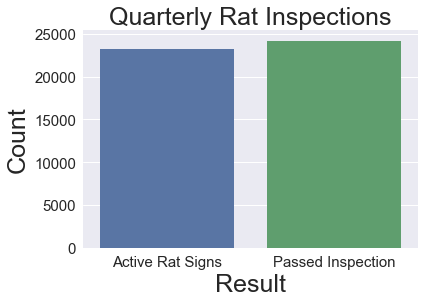

In [51]:
df_plot = df_f.groupby('RESULT', as_index=False)['AssessTot'].count()
#plt.figure(figsize=(15,10))
sns.barplot(df_plot.RESULT, df_plot.AssessTot)
plt.ylabel('Count', fontsize = 25)
plt.xlabel('Result',fontsize=25)
plt.title('Quarterly Rat Inspections', fontsize = 25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

In [52]:
from sklearn.preprocessing import StandardScaler
scalerX = StandardScaler().fit(X_train)
X_train_scale = scalerX.transform(X_train)
X_test_scale = scalerX.transform(X_test)

In [53]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(tol=.0001)
lr.fit(X_train, y_train)
print('Train Accuracy: ' + str(accuracy_score(y_train,lr.predict(X_train_scale))))
print('Accuracy: ' + str(accuracy_score(y_test,lr.predict(X_test_scale))))
print('Precision: ' + str(precision_score(y_test,lr.predict(X_test_scale), pos_label = 'Active Rat Signs')))
print('Recall: ' + str(recall_score(y_test,lr.predict(X_test_scale), pos_label = 'Active Rat Signs')))
print('F1: ' + str(f1_score(y_test,lr.predict(X_test_scale), pos_label = 'Active Rat Signs')))

Train Accuracy: 0.626376694692
Accuracy: 0.6262113521
Precision: 0.613824792728
Recall: 0.773053214241
F1: 0.68429844098


In [54]:
tn, fp, fn, tp = confusion_matrix(y_test,lr.predict(X_test_scale)).ravel()
print('True Positives: ' + str(tp))
print('True Negatives: ' + str(tn))
print('False Positives: ' + str(fp))
print('False Negatives: ' + str(fn))

True Positives: 3354
True Negatives: 6145
False Positives: 1804
False Negatives: 3866


In [55]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train_scale, y_train)
print('Train Accuracy: ' + str(accuracy_score(y_train,nb.predict(X_train_scale))))
print('Accuracy: ' + str(accuracy_score(y_test,nb.predict(X_test_scale))))
print('Precision: ' + str(precision_score(y_test,nb.predict(X_test_scale), pos_label = 'Active Rat Signs')))
print('Recall: ' + str(recall_score(y_test,nb.predict(X_test_scale), pos_label = 'Active Rat Signs')))
print('F1: ' + str(f1_score(y_test,nb.predict(X_test_scale), pos_label = 'Active Rat Signs')))

Train Accuracy: 0.636738746006
Accuracy: 0.658316302986
Precision: 0.620680628272
Recall: 0.894829538307
F1: 0.732958936576


In [56]:
tp, fn, fp, tn = confusion_matrix(y_test,nb.predict(X_test_scale)).ravel()
print('True Positives: ' + str(tp))
print('True Negatives: ' + str(tn))
print('False Positives: ' + str(fp))
print('False Negatives: ' + str(fn))

True Positives: 7113
True Negatives: 2873
False Positives: 4347
False Negatives: 836


In [57]:
from sklearn.naive_bayes import BernoulliNB
mnb = BernoulliNB()
mnb.fit(X_train_scale, y_train)
print('Train Accuracy: ' + str(accuracy_score(y_train,mnb.predict(X_train_scale))))
print('Accuracy: ' + str(accuracy_score(y_test,mnb.predict(X_test_scale))))
print('Precision: ' + str(precision_score(y_test,mnb.predict(X_test_scale), pos_label = 'Active Rat Signs')))
print('Recall: ' + str(recall_score(y_test,mnb.predict(X_test_scale), pos_label = 'Active Rat Signs')))
print('F1: ' + str(f1_score(y_test,mnb.predict(X_test_scale), pos_label = 'Active Rat Signs')))

Train Accuracy: 0.6762324326
Accuracy: 0.678686795438
Precision: 0.691017517704
Recall: 0.699710655428
F1: 0.695336917115


### ROC Curve

In [58]:
y_test_bin = [0 if i == 'Active Rat Signs' else 1 for i in y_test]

In [59]:
predicted_probs_rf = clf.predict_proba(X_test)
predicted_probs_nb = nb.predict_proba(X_test_scale)
#predicted_probs_mnb = mnb.predict_proba(X_test_scale)
predicted_probs_lr = lr.predict_proba(X_test)

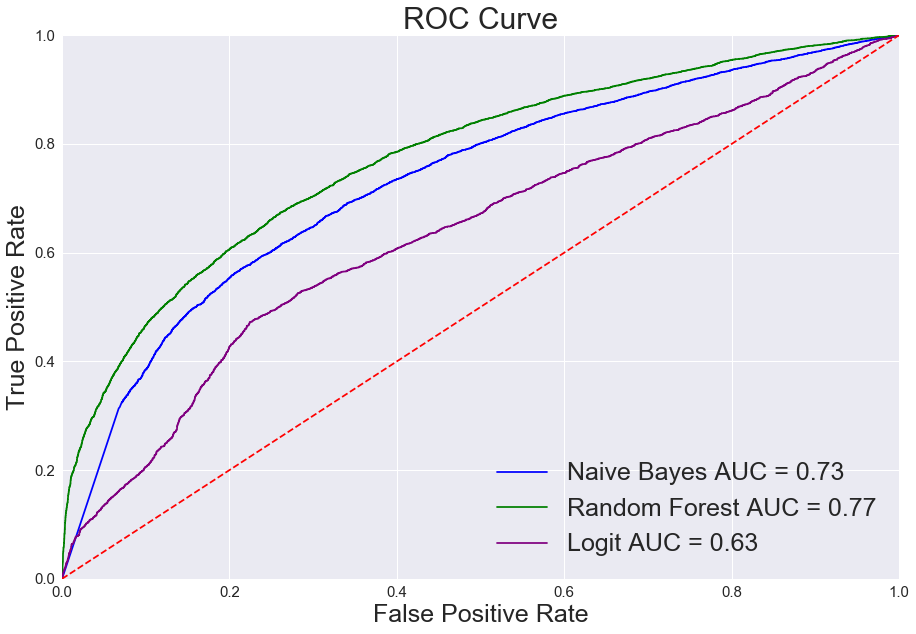

In [60]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

plt.figure(figsize=(15,10))
fpr, tpr, threshold = roc_curve(y_test_bin, predicted_probs_nb[:,1])
roc_auc = auc(fpr, tpr)
fpr_2, tpr_2, threshold_2 = roc_curve(y_test_bin, predicted_probs_rf[:,1])
roc_auc_2 = auc(fpr_2, tpr_2)
#fpr_3, tpr_3, threshold_3 = roc_curve(y_test_bin, predicted_probs_mnb[:,1])
#roc_auc_3 = auc(fpr_3, tpr_3)
fpr_4, tpr_4, threshold_4 = roc_curve(y_test_bin, predicted_probs_lr[:,1])
roc_auc_4 = auc(fpr_4, tpr_4)
plt.title('ROC Curve', fontsize=30)
plt.plot(fpr, tpr, 'b', label = 'Naive Bayes AUC = %0.2f' % roc_auc)
plt.plot(fpr_2, tpr_2, label = 'Random Forest AUC = %0.2f' % roc_auc_2, color='green')
#plt.plot(fpr_3, tpr_3, label = 'GNB AUC = %0.2f' % roc_auc_3, color='purple')
plt.plot(fpr_4, tpr_4, label = 'Logit AUC = %0.2f' % roc_auc_4, color='purple')
plt.legend(loc = 'lower right', fontsize=25)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=25)
plt.xlabel('False Positive Rate', fontsize=25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

plt.show()
